# 02. Data Preprocessing & Feature Engineering

## Muc tieu
- Xu ly outliers (dac biet huyet ap)
- Tao cac features moi (BMI, pulse_pressure)
- Chuan hoa du lieu
- Chia train/val/test theo ty le 70/15/15

In [45]:
# Import thu vien
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

import warnings
warnings.filterwarnings('ignore')

# Cau hinh hien thi
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load du lieu goc

In [46]:
# Doc du lieu
df = pd.read_csv('DataRaw/cardio_train.csv', sep=';')

print(f"Kich thuoc ban dau: {df.shape[0]:,} dong x {df.shape[1]} cot")
df.head()

Kich thuoc ban dau: 70,000 dong x 13 cot


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 2. Xu ly Outliers

In [47]:
# Thong ke truoc khi xu ly
print("TRUOC KHI XU LY OUTLIERS:")
print(f"Tong so mau: {len(df):,}")
print(f"\nHuyet ap tam thu (ap_hi): min={df['ap_hi'].min()}, max={df['ap_hi'].max()}")
print(f"Huyet ap tam truong (ap_lo): min={df['ap_lo'].min()}, max={df['ap_lo'].max()}")
print(f"Chieu cao (height): min={df['height'].min()}, max={df['height'].max()}")
print(f"Can nang (weight): min={df['weight'].min()}, max={df['weight'].max()}")

TRUOC KHI XU LY OUTLIERS:
Tong so mau: 70,000

Huyet ap tam thu (ap_hi): min=-150, max=16020
Huyet ap tam truong (ap_lo): min=-70, max=11000
Chieu cao (height): min=55, max=250
Can nang (weight): min=10.0, max=200.0


In [48]:
# Dinh nghia nguong outliers
# Dua tren kien thuc y hoc ve huyet ap binh thuong

# Huyet ap tam thu: 70-250 mmHg (cho phep ca truong hop cao bat thuong)
# Huyet ap tam truong: 40-200 mmHg
# Chieu cao: 100-220 cm (hop ly cho nguoi truong thanh)
# Can nang: 30-200 kg

print("Nguong loai bo outliers:")
print("  ap_hi: [70, 250]")
print("  ap_lo: [40, 200]")
print("  ap_lo < ap_hi (dieu kien bat buoc)")
print("  height: [100, 220]")
print("  weight: [30, 200]")

Nguong loai bo outliers:
  ap_hi: [70, 250]
  ap_lo: [40, 200]
  ap_lo < ap_hi (dieu kien bat buoc)
  height: [100, 220]
  weight: [30, 200]


In [49]:
# Dem so outliers theo tung dieu kien
print("\nSo luong outliers theo tung dieu kien:")

outlier_ap_hi_low = (df['ap_hi'] < 70).sum()
outlier_ap_hi_high = (df['ap_hi'] > 250).sum()
outlier_ap_lo_low = (df['ap_lo'] < 40).sum()
outlier_ap_lo_high = (df['ap_lo'] > 200).sum()
outlier_ap_logic = (df['ap_lo'] >= df['ap_hi']).sum()
outlier_height_low = (df['height'] < 100).sum()
outlier_height_high = (df['height'] > 220).sum()
outlier_weight_low = (df['weight'] < 30).sum()
outlier_weight_high = (df['weight'] > 200).sum()

print(f"  ap_hi < 70: {outlier_ap_hi_low}")
print(f"  ap_hi > 250: {outlier_ap_hi_high}")
print(f"  ap_lo < 40: {outlier_ap_lo_low}")
print(f"  ap_lo > 200: {outlier_ap_lo_high}")
print(f"  ap_lo >= ap_hi: {outlier_ap_logic}")
print(f"  height < 100: {outlier_height_low}")
print(f"  height > 220: {outlier_height_high}")
print(f"  weight < 30: {outlier_weight_low}")
print(f"  weight > 200: {outlier_weight_high}")


So luong outliers theo tung dieu kien:
  ap_hi < 70: 189
  ap_hi > 250: 40
  ap_lo < 40: 59
  ap_lo > 200: 953
  ap_lo >= ap_hi: 1236
  height < 100: 29
  height > 220: 1
  weight < 30: 7
  weight > 200: 0


In [50]:
# Loai bo outliers
df_clean = df[
    (df['ap_hi'] >= 70) & (df['ap_hi'] <= 250) &
    (df['ap_lo'] >= 40) & (df['ap_lo'] <= 200) &
    (df['ap_hi'] > df['ap_lo']) &
    (df['height'] >= 100) & (df['height'] <= 220) &
    (df['weight'] >= 30) & (df['weight'] <= 200)
].copy()

so_bi_loai = len(df) - len(df_clean)
ty_le_loai = so_bi_loai / len(df) * 100

print(f"\nSAU KHI XU LY OUTLIERS:")
print(f"  So mau con lai: {len(df_clean):,}")
print(f"  So mau bi loai: {so_bi_loai:,} ({ty_le_loai:.2f}%)")


SAU KHI XU LY OUTLIERS:
  So mau con lai: 68,638
  So mau bi loai: 1,362 (1.95%)


In [51]:
# Kiem tra lai pham vi sau xu ly
print("\nPham vi sau xu ly:")
print(f"  ap_hi: [{df_clean['ap_hi'].min()}, {df_clean['ap_hi'].max()}]")
print(f"  ap_lo: [{df_clean['ap_lo'].min()}, {df_clean['ap_lo'].max()}]")
print(f"  height: [{df_clean['height'].min()}, {df_clean['height'].max()}]")
print(f"  weight: [{df_clean['weight'].min()}, {df_clean['weight'].max()}]")


Pham vi sau xu ly:
  ap_hi: [70, 240]
  ap_lo: [40, 182]
  height: [100, 207]
  weight: [30.0, 200.0]


## 3. Feature Engineering

In [52]:
# Tao cac features moi

# 1. Chuyen age tu ngay sang nam
df_clean['age_years'] = df_clean['age'] / 365.25

# 2. Tinh BMI (Body Mass Index)
df_clean['bmi'] = df_clean['weight'] / ((df_clean['height'] / 100) ** 2)

# 3. Tinh Pulse Pressure (chenh lech huyet ap)
df_clean['pulse_pressure'] = df_clean['ap_hi'] - df_clean['ap_lo']

# 4. Tinh MAP (Mean Arterial Pressure) - Huyet ap dong mach trung binh
df_clean['map'] = (df_clean['ap_hi'] + 2 * df_clean['ap_lo']) / 3

print("Cac features moi da tao:")
print("  1. age_years: Tuoi tinh bang nam")
print("  2. bmi: Chi so khoi co the")
print("  3. pulse_pressure: Chenh lech huyet ap (ap_hi - ap_lo)")
print("  4. map: Huyet ap dong mach trung binh")

Cac features moi da tao:
  1. age_years: Tuoi tinh bang nam
  2. bmi: Chi so khoi co the
  3. pulse_pressure: Chenh lech huyet ap (ap_hi - ap_lo)
  4. map: Huyet ap dong mach trung binh


In [53]:
# Thong ke cac features moi
new_features = ['age_years', 'bmi', 'pulse_pressure', 'map']
print("\nThong ke cac features moi:")
df_clean[new_features].describe()


Thong ke cac features moi:


,age_years,bmi,pulse_pressure,map
count,68638.000000,68638.000000,68638.000000,68638.000000
mean,53.291545,27.473179,45.368571,96.431068
std,6.757221,5.351367,11.666812,11.055382
min,29.563313,10.726644,5.000000,50.000000
25%,48.344969,23.875115,40.000000,93.333333
50%,53.939767,26.346494,40.000000,93.333333
75%,58.383984,30.119376,50.000000,103.333333
max,64.922656,152.551775,140.000000,186.666667


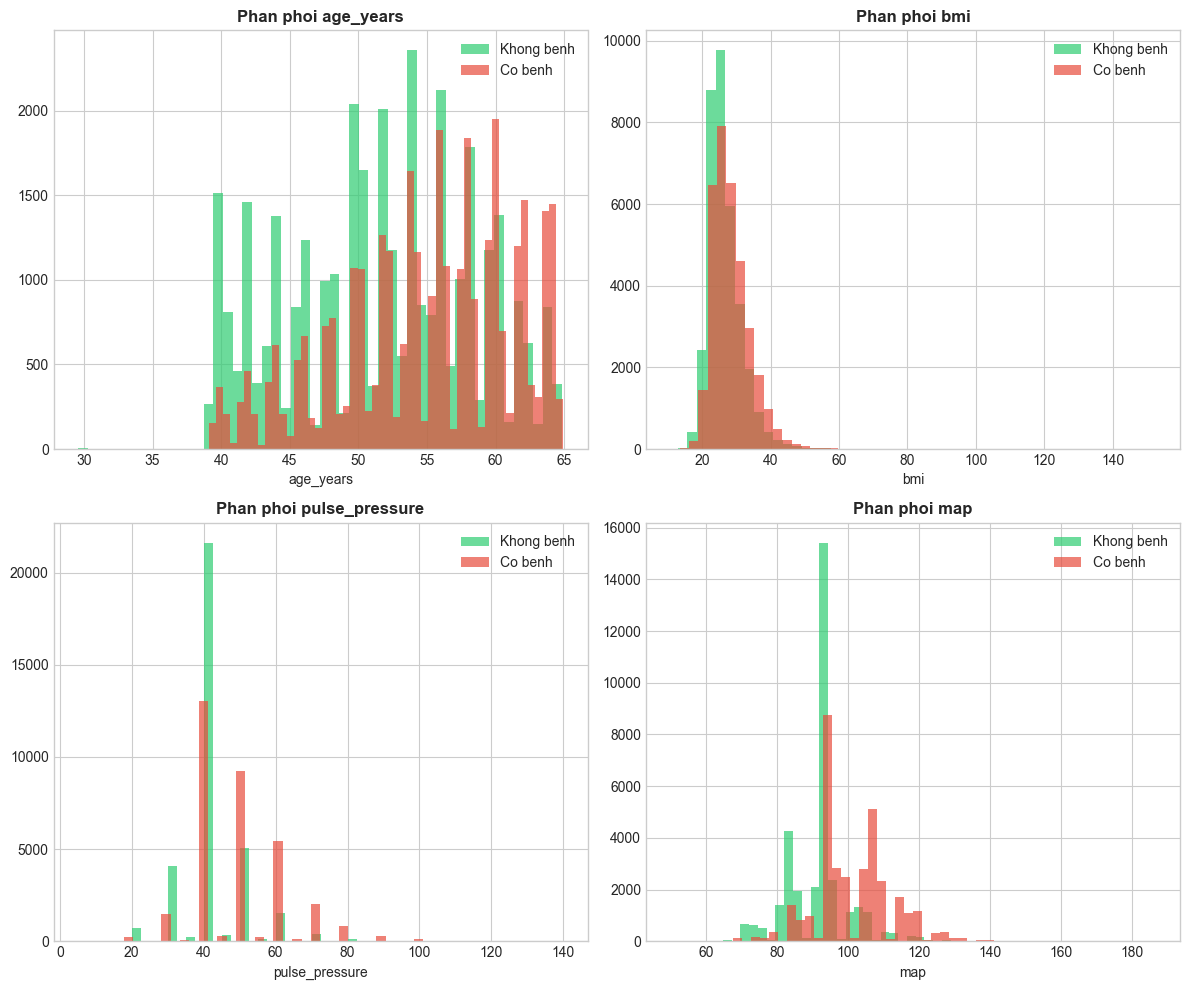

In [54]:
# Visualization cac features moi
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, col in enumerate(new_features):
    ax = axes[i // 2, i % 2]
    
    df_clean[df_clean['cardio']==0][col].hist(ax=ax, bins=50, alpha=0.7, 
                                               label='Khong benh', color='#2ecc71')
    df_clean[df_clean['cardio']==1][col].hist(ax=ax, bins=50, alpha=0.7, 
                                               label='Co benh', color='#e74c3c')
    ax.set_title(f'Phan phoi {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.legend()

plt.tight_layout()
plt.savefig('outputs/09_new_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Chuan bi Features va Target

In [55]:
# Danh sach features se su dung
feature_cols = [
    'age_years',      # Tuoi (nam)
    'gender',         # Gioi tinh
    'height',         # Chieu cao
    'weight',         # Can nang
    'ap_hi',          # Huyet ap tam thu
    'ap_lo',          # Huyet ap tam truong
    'cholesterol',    # Muc cholesterol
    'gluc',           # Muc glucose
    'smoke',          # Hut thuoc
    'alco',           # Uong ruou
    'active',         # Hoat dong the chat
    'bmi',            # Chi so BMI (moi)
    'pulse_pressure', # Chenh lech huyet ap (moi)
    'map'             # Huyet ap trung binh (moi)
]

target_col = 'cardio'

print(f"So luong features: {len(feature_cols)}")
print(f"Danh sach features: {feature_cols}")

So luong features: 14
Danh sach features: ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'pulse_pressure', 'map']


In [56]:
# Tach X va y
X = df_clean[feature_cols].copy()
y = df_clean[target_col].copy()

print(f"Kich thuoc X: {X.shape}")
print(f"Kich thuoc y: {y.shape}")
print(f"\nPhan phoi y:")
print(y.value_counts())

Kich thuoc X: (68638, 14)
Kich thuoc y: (68638,)

Phan phoi y:
cardio
0    34680
1    33958
Name: count, dtype: int64


## 5. Chia Train/Val/Test (70/15/15)

In [57]:
# Chia du lieu theo ty le 70/15/15
# Buoc 1: Chia thanh train (70%) va temp (30%)
# Buoc 2: Chia temp thanh val (15%) va test (15%)

RANDOM_STATE = 42

# Chia train va temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30,  # 30% cho val + test
    random_state=RANDOM_STATE,
    stratify=y  # Dam bao ty le class can bang
)

# Chia temp thanh val va test (50-50 cua 30% = 15% moi phan)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,  # 50% cua 30% = 15% tong
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("DA CHIA DU LIEU:")
print(f"  Train set: {len(X_train):,} mau ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val set:   {len(X_val):,} mau ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set:  {len(X_test):,} mau ({len(X_test)/len(X)*100:.1f}%)")

DA CHIA DU LIEU:
  Train set: 48,046 mau (70.0%)
  Val set:   10,296 mau (15.0%)
  Test set:  10,296 mau (15.0%)


In [58]:
# Kiem tra phan phoi class trong moi tap
print("\nPHAN PHOI CLASS TRONG MOI TAP:")
print(f"  Train - Class 0: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.2f}%)")
print(f"  Train - Class 1: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.2f}%)")
print(f"\n  Val   - Class 0: {(y_val==0).sum():,} ({(y_val==0).mean()*100:.2f}%)")
print(f"  Val   - Class 1: {(y_val==1).sum():,} ({(y_val==1).mean()*100:.2f}%)")
print(f"\n  Test  - Class 0: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.2f}%)")
print(f"  Test  - Class 1: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.2f}%)")


PHAN PHOI CLASS TRONG MOI TAP:
  Train - Class 0: 24,276 (50.53%)
  Train - Class 1: 23,770 (49.47%)

  Val   - Class 0: 5,202 (50.52%)
  Val   - Class 1: 5,094 (49.48%)

  Test  - Class 0: 5,202 (50.52%)
  Test  - Class 1: 5,094 (49.48%)


## 6. Feature Scaling (Chuan hoa du lieu)

In [59]:
# Cac features can scale (bien lien tuc)
features_to_scale = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 
                     'bmi', 'pulse_pressure', 'map']

# Cac features khong can scale (binary hoac ordinal)
features_no_scale = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

print(f"Features can scale ({len(features_to_scale)}): {features_to_scale}")
print(f"Features khong scale ({len(features_no_scale)}): {features_no_scale}")

Features can scale (8): ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'pulse_pressure', 'map']
Features khong scale (6): ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


In [60]:
# Khoi tao StandardScaler
scaler = StandardScaler()

# Fit tren train set va transform
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Fit va transform tren train
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Chi transform tren val va test (su dung cung tham so tu train)
X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Da scale xong du lieu!")
print("\nThong ke sau khi scale (Train set):")
X_train_scaled[features_to_scale].describe().round(2)

Da scale xong du lieu!

Thong ke sau khi scale (Train set):


,age_years,height,weight,ap_hi,ap_lo,bmi,pulse_pressure,map
count,48046.00,48046.00,48046.00,48046.00,48046.00,48046.00,48046.00,48046.00
mean,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.49,-8.06,-3.08,-3.39,-4.36,-2.93,-3.46,-4.19
25%,-0.73,-0.68,-0.64,-0.40,-0.14,-0.67,-0.46,-0.28
50%,0.09,0.07,-0.15,-0.40,-0.14,-0.21,-0.46,-0.28
75%,0.75,0.70,0.55,0.80,0.92,0.49,0.40,0.62
max,1.72,4.21,8.79,6.78,10.63,23.30,8.12,8.14


In [61]:
# Luu scaler de su dung sau nay
joblib.dump(scaler, 'models/scaler.pkl')
print("Da luu scaler: models/scaler.pkl")

Da luu scaler: models/scaler.pkl


## 7. Luu du lieu da xu ly

In [62]:
# Luu cac file du lieu

# Luu dang numpy array (.npy) - nhanh hon khi load
np.save('data/X_train.npy', X_train_scaled.values)
np.save('data/X_val.npy', X_val_scaled.values)
np.save('data/X_test.npy', X_test_scaled.values)
np.save('data/y_train.npy', y_train.values)
np.save('data/y_val.npy', y_val.values)
np.save('data/y_test.npy', y_test.values)

# Luu danh sach ten features
np.save('data/feature_names.npy', np.array(feature_cols))

print("Da luu cac file:")
print("  data/X_train.npy")
print("  data/X_val.npy")
print("  data/X_test.npy")
print("  data/y_train.npy")
print("  data/y_val.npy")
print("  data/y_test.npy")
print("  data/feature_names.npy")

Da luu cac file:
  data/X_train.npy
  data/X_val.npy
  data/X_test.npy
  data/y_train.npy
  data/y_val.npy
  data/y_test.npy
  data/feature_names.npy


In [63]:
# Luu them dang CSV de de xem
X_train_scaled.to_csv('data/X_train.csv', index=False)
X_val_scaled.to_csv('data/X_val.csv', index=False)
X_test_scaled.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_val.to_csv('data/y_val.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

print("\nDa luu them dang CSV de de xem:")
print("  data/X_train.csv, X_val.csv, X_test.csv")
print("  data/y_train.csv, y_val.csv, y_test.csv")


Da luu them dang CSV de de xem:
  data/X_train.csv, X_val.csv, X_test.csv
  data/y_train.csv, y_val.csv, y_test.csv


In [64]:
# Luu du lieu goc da xu ly outliers (chua scale) de tham khao
df_clean.to_csv('data/cardio_cleaned.csv', index=False)
print("\nDa luu du lieu goc da lam sach: data/cardio_cleaned.csv")


Da luu du lieu goc da lam sach: data/cardio_cleaned.csv


## 8. Tong ket

In [65]:
print("=" * 60)
print("TONG KET PREPROCESSING")
print("=" * 60)

print("\n1. XU LY OUTLIERS:")
print(f"   - Du lieu goc: {len(df):,} mau")
print(f"   - Sau xu ly: {len(df_clean):,} mau")
print(f"   - Loai bo: {so_bi_loai:,} mau ({ty_le_loai:.2f}%)")

print("\n2. FEATURE ENGINEERING:")
print(f"   - Features goc: 11")
print(f"   - Features moi: 3 (age_years, bmi, pulse_pressure, map)")
print(f"   - Tong features: {len(feature_cols)}")

print("\n3. CHIA DU LIEU:")
print(f"   - Train: {len(X_train):,} mau (70%)")
print(f"   - Val:   {len(X_val):,} mau (15%)")
print(f"   - Test:  {len(X_test):,} mau (15%)")

print("\n4. SCALING:")
print(f"   - StandardScaler cho {len(features_to_scale)} features")
print(f"   - Scaler da luu: models/scaler.pkl")

print("\n5. FILES DA LUU:")
print("   - data/X_train.npy, X_val.npy, X_test.npy")
print("   - data/y_train.npy, y_val.npy, y_test.npy")
print("   - data/feature_names.npy")
print("   - models/scaler.pkl")

TONG KET PREPROCESSING

1. XU LY OUTLIERS:
   - Du lieu goc: 70,000 mau
   - Sau xu ly: 68,638 mau
   - Loai bo: 1,362 mau (1.95%)

2. FEATURE ENGINEERING:
   - Features goc: 11
   - Features moi: 3 (age_years, bmi, pulse_pressure, map)
   - Tong features: 14

3. CHIA DU LIEU:
   - Train: 48,046 mau (70%)
   - Val:   10,296 mau (15%)
   - Test:  10,296 mau (15%)

4. SCALING:
   - StandardScaler cho 8 features
   - Scaler da luu: models/scaler.pkl

5. FILES DA LUU:
   - data/X_train.npy, X_val.npy, X_test.npy
   - data/y_train.npy, y_val.npy, y_test.npy
   - data/feature_names.npy
   - models/scaler.pkl


In [66]:
# Kiem tra final - doc lai du lieu de dam bao khong loi
print("\nKIEM TRA LAI DU LIEU DA LUU:")
X_train_check = np.load('data/X_train.npy')
y_train_check = np.load('data/y_train.npy')
print(f"  X_train shape: {X_train_check.shape}")
print(f"  y_train shape: {y_train_check.shape}")
print("\n>> Du lieu da san sang cho buoc tiep theo: Train Single Models!")


KIEM TRA LAI DU LIEU DA LUU:
  X_train shape: (48046, 14)
  y_train shape: (48046,)

>> Du lieu da san sang cho buoc tiep theo: Train Single Models!
